In [39]:
%pip install torch transformers scikit-learn pandas numpy matplotlib seaborn tqdm nlpaug nltk datasets tf-keras accelerate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [40]:
# Data Loading and Inspection
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample
import re
import string
from nlpaug.augmenter.word import SynonymAug
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data_path = '../../Data/Dataset_2.csv'
df = pd.read_csv(data_path, encoding='latin1', delimiter=',', quotechar='"')

# Inspect the dataset
print(df.head())
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(subset=['tweet'], inplace=True)

# Map classes to binary labels
df['label'] = df['class'].apply(lambda x: 1 if x == 0 else 0)  # 1: Hate Speech, 0: Non-Hate Speech

# Drop unnecessary columns
df = df[['tweet', 'label']]

# Check class distribution
print(df['label'].value_counts())

# Data Preprocessing
# Check your preprocessing function
def preprocess_text(text):
    # Make sure this function matches EXACTLY what you used during training
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    return text

df['clean_tweet'] = df['tweet'].apply(preprocess_text)

# Separate majority and minority classes
df_majority = df[df.label == 0]
df_minority = df[df.label == 1]

# For upsampling the minority class (recommended when data is limited)
df_minority_upsampled = resample(df_minority, 
                               replace=True,     
                               n_samples=len(df_majority),    
                               random_state=42)  
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Verify balanced class distribution
print(df_balanced['label'].value_counts())

# Tokenization
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and encode data
def encode_data(texts, tokenizer, max_length=128):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    return encodings

# Encode training and testing data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced['clean_tweet'], df_balanced['label'], test_size=0.2, random_state=42, stratify=df_balanced['label']
)

train_encodings = encode_data(train_texts, tokenizer)
val_encodings = encode_data(val_texts, tokenizer)

# Dataset Creation for BERT
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

# Create datasets
train_dataset = HateSpeechDataset(train_encodings, train_labels)
val_dataset = HateSpeechDataset(val_encodings, val_labels)

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          100 non

C:\Users\Aditya Mohan Khade\AppData\Roaming\Python\Python310\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [41]:
# BERT Model Training
# Initialize model
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, use_cache=False, gradient_checkpointing=True)

# Define training arguments
training_args_bert = TrainingArguments(
    output_dir='./results_bert',
    evaluation_strategy='epoch',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    fp16=True, 
    fp16_full_eval=True,
)

# Initialize trainer
trainer_bert = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer_bert.train()

# Evaluate the model
results_bert = trainer_bert.evaluate()
print(results_bert)

# BERT Model Evaluation
# Predict on validation set
predictions_bert = trainer_bert.predict(val_dataset)
pred_labels_bert = predictions_bert.predictions.argmax(-1)

# Generate classification report
print(classification_report(val_labels, pred_labels_bert, target_names=['Non-Hate Speech', 'Hate Speech']))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Aditya Mohan Khade\AppData\Roaming\Python\Python310\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 10%|█         | 10/100 [00:40<04:50,  3.22s/it]

{'eval_loss': 0.31874880194664, 'eval_runtime': 1.1731, 'eval_samples_per_second': 34.098, 'eval_steps_per_second': 2.557, 'epoch': 1.0}


 20%|██        | 20/100 [01:09<03:26,  2.58s/it]

{'eval_loss': 0.09574200958013535, 'eval_runtime': 0.9606, 'eval_samples_per_second': 41.642, 'eval_steps_per_second': 3.123, 'epoch': 2.0}


 30%|███       | 30/100 [01:36<02:54,  2.50s/it]

{'eval_loss': 0.010865624994039536, 'eval_runtime': 0.9663, 'eval_samples_per_second': 41.394, 'eval_steps_per_second': 3.105, 'epoch': 3.0}


 40%|████      | 40/100 [02:03<02:29,  2.50s/it]

{'eval_loss': 0.001685402006842196, 'eval_runtime': 0.96, 'eval_samples_per_second': 41.668, 'eval_steps_per_second': 3.125, 'epoch': 4.0}


 50%|█████     | 50/100 [02:29<02:02,  2.44s/it]

{'eval_loss': 0.0006598980398848653, 'eval_runtime': 0.9346, 'eval_samples_per_second': 42.797, 'eval_steps_per_second': 3.21, 'epoch': 5.0}


 60%|██████    | 60/100 [02:56<01:38,  2.47s/it]

{'eval_loss': 0.0004036347381770611, 'eval_runtime': 0.9844, 'eval_samples_per_second': 40.633, 'eval_steps_per_second': 3.048, 'epoch': 6.0}


 70%|███████   | 70/100 [03:22<01:13,  2.47s/it]

{'eval_loss': 0.000332543917465955, 'eval_runtime': 0.9639, 'eval_samples_per_second': 41.498, 'eval_steps_per_second': 3.112, 'epoch': 7.0}


 80%|████████  | 80/100 [03:49<00:49,  2.47s/it]

{'eval_loss': 0.0003006923361681402, 'eval_runtime': 0.9529, 'eval_samples_per_second': 41.977, 'eval_steps_per_second': 3.148, 'epoch': 8.0}


 90%|█████████ | 90/100 [04:15<00:24,  2.45s/it]

{'eval_loss': 0.00028606070554815233, 'eval_runtime': 0.9904, 'eval_samples_per_second': 40.388, 'eval_steps_per_second': 3.029, 'epoch': 9.0}


100%|██████████| 100/100 [04:43<00:00,  2.84s/it]


{'eval_loss': 0.00028096893220208585, 'eval_runtime': 1.0171, 'eval_samples_per_second': 39.329, 'eval_steps_per_second': 2.95, 'epoch': 10.0}
{'train_runtime': 283.8578, 'train_samples_per_second': 5.496, 'train_steps_per_second': 0.352, 'train_loss': 0.08058684349060058, 'epoch': 10.0}


100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


{'eval_loss': 0.0, 'eval_runtime': 4.4536, 'eval_samples_per_second': 8.981, 'eval_steps_per_second': 0.674, 'epoch': 10.0}


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                 precision    recall  f1-score   support

Non-Hate Speech       1.00      1.00      1.00        20
    Hate Speech       1.00      1.00      1.00        20

       accuracy                           1.00        40
      macro avg       1.00      1.00      1.00        40
   weighted avg       1.00      1.00      1.00        40



In [42]:
# LSTM + CNN Model Definition
import torch.nn as nn
import torch.nn.functional as F

class LSTM_CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_hidden_dim, cnn_hidden_dim, num_classes, dropout=0.5):
        super(LSTM_CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, lstm_hidden_dim, batch_first=True, bidirectional=True)
        self.conv1d = nn.Conv1d(lstm_hidden_dim*2, cnn_hidden_dim, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(cnn_hidden_dim, num_classes)
    
    def forward(self, x):
        # Handle both float and long inputs
        if x.dtype == torch.float32:
            x = x.long()
        
        # Embedding layer
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        
        # LSTM layer
        lstm_out, _ = self.lstm(embedded)  # [batch_size, seq_len, lstm_hidden_dim*2]
        
        # Reshape for CNN: [batch_size, lstm_hidden_dim*2, seq_len]
        lstm_out = lstm_out.permute(0, 2, 1)
        
        # Apply CNN
        conv_out = F.relu(self.conv1d(lstm_out))  # [batch_size, cnn_hidden_dim, seq_len]
        
        # Pooling
        pooled = self.pool(conv_out).squeeze(-1)  # [batch_size, cnn_hidden_dim]
        
        # Dropout and final classification
        dropped = self.dropout(pooled)
        output = self.fc(dropped)  # [batch_size, num_classes]
        
        return output

In [43]:
# Vocabulary Building and Text Sequencing
from collections import Counter

# Build vocabulary
def build_vocab(texts, max_vocab_size=10000):
    counter = Counter()
    for text in texts:
        tokens = text.split()  # Simple whitespace-based tokenization
        counter.update(tokens)
    vocab = {word: idx + 1 for idx, (word, _) in enumerate(counter.most_common(max_vocab_size))}
    vocab[' '] = 0  # Padding token
    return vocab

# Convert text to sequences
def text_to_sequence(text, vocab, max_len=100):
    tokens = text.split()
    sequence = [vocab.get(token, 0) for token in tokens]  # Use 0 for unknown tokens
    sequence = sequence[:max_len]  # Truncate if longer than max_len 
    sequence += [0] * (max_len - len(sequence))  # Pad if shorter than max_len
    return sequence

# Build vocabulary from the dataset
vocab = build_vocab(df_balanced['clean_tweet'], max_vocab_size=10000)

# Convert all texts to sequences
X_sequences = [text_to_sequence(text, vocab, max_len=100) for text in df_balanced['clean_tweet']]
X_sequences = torch.tensor(X_sequences, dtype=torch.long)


# Split data (convert labels to NumPy array)
X_train, X_val, y_train, y_val = train_test_split(
    X_sequences, 
    df_balanced['label'].values,  # Convert to NumPy array
    test_size=0.2, 
    random_state=42, 
    stratify=df_balanced['label']
)

# Create datasets for LSTM + CNN
class HateSpeechDatasetLSTM_CNN(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        # Convert labels to a numpy array if it's a pandas Series
        self.labels = torch.tensor(labels.to_numpy() if isinstance(labels, pd.Series) else labels)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create datasets for LSTM + CNN
train_dataset_lstm_cnn = HateSpeechDatasetLSTM_CNN(X_train, y_train)
val_dataset_lstm_cnn = HateSpeechDatasetLSTM_CNN(X_val, y_val)

In [44]:
# Define hyperparameters for LSTM + CNN
vocab_size = len(vocab)
embed_dim = 100
lstm_hidden_dim = 128
cnn_hidden_dim = 128
num_classes = 2
dropout = 0.5

# Initialize model for LSTM + CNN
model_lstm_cnn = LSTM_CNN(vocab_size, embed_dim, lstm_hidden_dim, cnn_hidden_dim, num_classes, dropout)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm_cnn.parameters(), lr=1e-3)

# Define training loop for LSTM + CNN
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids, labels = batch
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}')
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, labels = batch
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {correct/total}')

# Create DataLoader for LSTM + CNN
train_loader = DataLoader(train_dataset_lstm_cnn, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset_lstm_cnn, batch_size=16, shuffle=False)

# Train the LSTM + CNN model
train_model(model_lstm_cnn, criterion, optimizer, train_loader, val_loader, num_epochs=10)

Epoch 1/10, Loss: 0.4996066361665726
Validation Loss: 0.2966541697581609, Accuracy: 1.0
Epoch 2/10, Loss: 0.15125424563884735
Validation Loss: 0.057566589365402855, Accuracy: 1.0
Epoch 3/10, Loss: 0.017804408888332547
Validation Loss: 0.005842453179260095, Accuracy: 1.0
Epoch 4/10, Loss: 0.0019964916107710453
Validation Loss: 0.0011778951350909967, Accuracy: 1.0
Epoch 5/10, Loss: 0.0003936199733288959
Validation Loss: 0.0006650499708484858, Accuracy: 1.0
Epoch 6/10, Loss: 0.00020753161661559715
Validation Loss: 0.0004982521156004319, Accuracy: 1.0
Epoch 7/10, Loss: 0.00014954792277421802
Validation Loss: 0.0003876340148660044, Accuracy: 1.0
Epoch 8/10, Loss: 0.0001228118529979838
Validation Loss: 0.0003058744720571364, Accuracy: 1.0
Epoch 9/10, Loss: 0.00010806382197188213
Validation Loss: 0.00026091705755485844, Accuracy: 1.0
Epoch 10/10, Loss: 0.00010269130652886815
Validation Loss: 0.00023960685211932287, Accuracy: 1.0


In [45]:
# Data Augmentation
import nltk
import copy
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nlpaug.augmenter.word import SynonymAug

aug = SynonymAug(aug_src='wordnet')

def augment_text(text, augmenter, num_aug=5):
    try:
        augmented = augmenter.augment(text, n=num_aug)
        return augmented if augmented else []
    except Exception as e:
        print(f"Augmentation failed for text: {text}. Error: {str(e)}")
        return []

# Augment the dataset
augmented_texts = []
augmented_labels = []

# Reset index to ensure contiguous integer indexing
df_balanced = df_balanced.reset_index(drop=True)  # Critical fix

for i, text in enumerate(df_balanced['clean_tweet']):
    try:
        augmented = augment_text(text, aug)
        if len(augmented) > 0:
            augmented_texts.extend(augmented)
            augmented_labels.extend([df_balanced['label'].iloc[i]] * len(augmented))
    except Exception as e:
        print(f"Error augmenting text: {text}. Error: {e}")

# Verify lengths match
print(f"Augmented texts: {len(augmented_texts)}, Augmented labels: {len(augmented_labels)}")

# Create augmented DataFrame
df_augmented = pd.DataFrame({'clean_tweet': augmented_texts, 'label': augmented_labels})

# Combine and split data
df_combined = pd.concat([df_balanced, df_augmented]).reset_index(drop=True)

# Convert combined texts to sequences
X_combined = [text_to_sequence(text, vocab, max_len=100) for text in df_combined['clean_tweet']]
X_combined = torch.tensor(X_combined, dtype=torch.long)

# Split data with error handling
try:
    X_train_combined, X_val_combined, y_train_combined, y_val_combined = train_test_split(
        X_combined, df_combined['label'], test_size=0.2, random_state=42, stratify=df_combined['label']
    )
except ValueError:
    # Fallback if stratify fails
    X_train_combined, X_val_combined, y_train_combined, y_val_combined = train_test_split(
        X_combined, df_combined['label'], test_size=0.2, random_state=42
    )

# Create datasets for LSTM + CNN
train_dataset_combined = HateSpeechDatasetLSTM_CNN(X_train_combined, y_train_combined)
val_dataset_combined = HateSpeechDatasetLSTM_CNN(X_val_combined, y_val_combined)

# DataLoader
train_loader_combined = DataLoader(train_dataset_combined, batch_size=16, shuffle=True)
val_loader_combined = DataLoader(val_dataset_combined, batch_size=16, shuffle=False)

# Define hyperparameters for LSTM + CNN
vocab_size = len(vocab)
embed_dim = 100
lstm_hidden_dim = 128
cnn_hidden_dim = 128
num_classes = 2
dropout = 0.5

# Initialize model for LSTM + CNN
model_lstm_cnn = LSTM_CNN(vocab_size, embed_dim, lstm_hidden_dim, cnn_hidden_dim, num_classes, dropout)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm_cnn.parameters(), lr=1e-3)

# Define training loop for LSTM + CNN
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids, labels = batch
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}')
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, labels = batch
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {correct/total}')

# Train with augmented data
train_model(model_lstm_cnn, criterion, optimizer, train_loader_combined, val_loader_combined, num_epochs=10)

# Adversarial Training
from torch.autograd import Variable

def adversarial_train(model, criterion, optimizer, train_loader, val_loader, epsilon=0.01, num_epochs=10):
    device = next(model.parameters()).device
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for batch in train_loader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(device), labels.to(device)
            
            # STEP 1: Regular forward pass
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward(retain_graph=True)
            
            # STEP 2: Generate adversarial examples
            # Get embedding gradients
            emb_grad = None
            for name, param in model.named_parameters():
                if name == 'embedding.weight' and param.grad is not None:
                    emb_grad = param.grad
            
            if emb_grad is not None:
                # Create adversarial perturbation at the embedding level
                embedded = model.embedding(input_ids)
                embedded.retain_grad()
                
                # This could be improved with better gradient handling
                delta = epsilon * torch.sign(torch.index_select(emb_grad, 0, input_ids.view(-1)))
                delta = delta.view(input_ids.size(0), input_ids.size(1), -1)
                
                # Get perturbed embeddings
                embedded_adv = embedded.detach() + delta
                
                # Manual forward pass with perturbed embedding
                lstm_out, _ = model.lstm(embedded_adv)
                lstm_out = lstm_out.permute(0, 2, 1)
                conv_out = F.relu(model.conv1d(lstm_out))
                pooled = model.pool(conv_out).squeeze(-1)
                dropped = model.dropout(pooled)
                adv_outputs = model.fc(dropped)
                
                # Adversarial loss
                adv_loss = criterion(adv_outputs, labels)
                
                # Combine loss
                total_loss = loss + adv_loss
                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()
                
                epoch_loss += total_loss.item()
            else:
                # If no gradients, just use regular loss
                optimizer.step()
                epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}')
        
        # Evaluation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, labels = batch
                input_ids, labels = input_ids.to(device), labels.to(device)
                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_avg_loss = val_loss / len(val_loader)
        accuracy = correct / total
        print(f'Validation Loss: {val_avg_loss:.6f}, Accuracy: {accuracy:.4f}')

# Adversarial train LSTM + CNN
adversarial_train(model_lstm_cnn, criterion, optimizer, train_loader_combined, val_loader_combined, epsilon=0.01, num_epochs=10)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Aditya Mohan
[nltk_data]     Khade\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Aditya Mohan
[nltk_data]     Khade\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Aditya Mohan
[nltk_data]     Khade\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Augmented texts: 980, Augmented labels: 980
Epoch 1/10, Loss: 0.1318439114545334
Validation Loss: 0.0005439736346791809, Accuracy: 1.0
Epoch 2/10, Loss: 0.00023591931001307892
Validation Loss: 0.00012516919863022244, Accuracy: 1.0
Epoch 3/10, Loss: 6.658243393172536e-05
Validation Loss: 8.583356199475626e-05, Accuracy: 1.0
Epoch 4/10, Loss: 1.875829103112865e-05
Validation Loss: 1.0563711839495227e-05, Accuracy: 1.0
Epoch 5/10, Loss: 5.45374959005847e-06
Validation Loss: 7.226347088362673e-06, Accuracy: 1.0
Epoch 6/10, Loss: 4.7166689572057265e-06
Validation Loss: 6.3530472743877905e-06, Accuracy: 1.0
Epoch 7/10, Loss: 4.140167652236661e-06
Validation Loss: 5.341885237915752e-06, Accuracy: 1.0
Epoch 8/10, Loss: 3.60922817803531e-06
Validation Loss: 4.9910225849695655e-06, Accuracy: 1.0
Epoch 9/10, Loss: 3.1542053239579635e-06
Validation Loss: 4.296358080561428e-06, Accuracy: 1.0
Epoch 10/10, Loss: 2.7658589191313526e-06
Validation Loss: 3.67287726324624e-06, Accuracy: 1.0
Epoch 1/10, L

In [46]:
# First, add this line to define the device variable before using it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Predict on validation set using the adversarially trained model
model_lstm_cnn.eval()  # Use model_lstm_cnn instead of model_adv
preds_list_adv = []
true_labels_adv = []

try:
    with torch.no_grad():
        for batch in val_loader_combined:  # Use val_loader_combined instead of val_loader_adv
            # For standard PyTorch dataloaders which return (inputs, labels) tuples
            input_ids, labels = batch
            input_ids, labels = input_ids.to(device), labels.to(device)
            true_labels_adv.extend(labels.cpu().numpy())
            
            outputs = model_lstm_cnn(input_ids)
            preds = torch.argmax(outputs, dim=1)
                
            # Collect predictions
            preds_list_adv.extend(preds.cpu().numpy())
            
    # Generate classification report
    from sklearn.metrics import classification_report, accuracy_score
    
    print(f"Adversarial Model Accuracy: {accuracy_score(true_labels_adv, preds_list_adv):.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels_adv, preds_list_adv, target_names=['Non-Hate Speech', 'Hate Speech']))

except Exception as e:
    import traceback
    print(f"Error during evaluation: {e}")
    traceback.print_exc()

Using device: cpu
Adversarial Model Accuracy: 1.0000

Classification Report:
                 precision    recall  f1-score   support

Non-Hate Speech       1.00      1.00      1.00       118
    Hate Speech       1.00      1.00      1.00       118

       accuracy                           1.00       236
      macro avg       1.00      1.00      1.00       236
   weighted avg       1.00      1.00      1.00       236



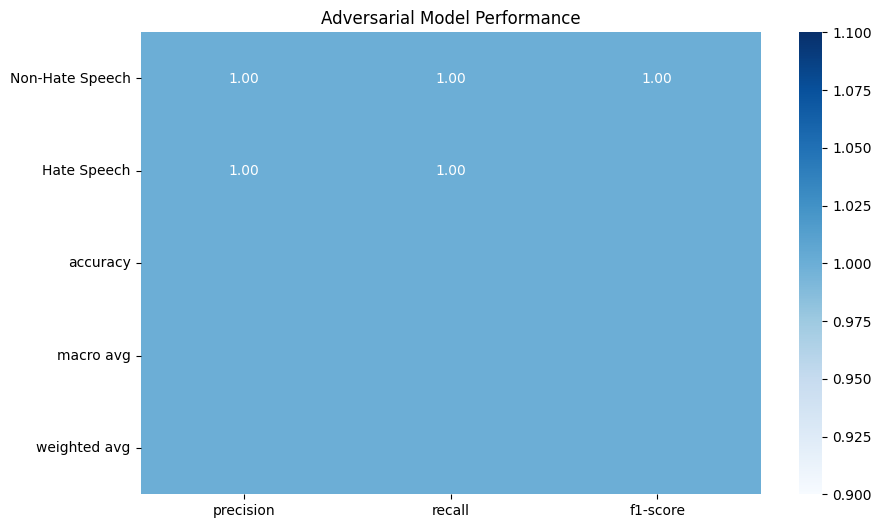

In [47]:
# Just plot the classification report for the adversarial model which you already have
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the function to plot classification report
def plot_classification_report(report, title):
    report_df = pd.DataFrame(report).iloc[:-1, :].T  
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df, annot=True, fmt=".2f", cmap='Blues')
    plt.title(title)
    plt.show()

# You already have true_labels_adv and preds_list_adv from your model evaluation
report = classification_report(true_labels_adv, preds_list_adv, 
                             target_names=['Non-Hate Speech', 'Hate Speech'], 
                             output_dict=True)
                             
plot_classification_report(report, "Adversarial Model Performance")

In [48]:
# Save the BERT model (which has save_pretrained)
model_bert.save_pretrained('./hate_speech_model_bert')
tokenizer.save_pretrained('./hate_speech_model_bert')

# Save the LSTM_CNN model using PyTorch's native saving method
model_info = {
    'state_dict': model_lstm_cnn.state_dict(),
    'vocab_size': len(vocab),
    'embed_dim': 100,
    'lstm_hidden_dim': 128,
    'cnn_hidden_dim': 128,
    'num_classes': 2,
    'dropout': 0.5
}
torch.save(model_info, './hate_speech_model_lstm_cnn.pth')

# Save the vocabulary for LSTM_CNN model
import pickle
with open('./vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

print("Models saved successfully!")

Models saved successfully!


In [49]:
# Loading the BERT model
from transformers import BertForSequenceClassification, BertTokenizer

loaded_bert_model = BertForSequenceClassification.from_pretrained('./hate_speech_model_bert')
loaded_tokenizer = BertTokenizer.from_pretrained('./hate_speech_model_bert')

# Loading the LSTM_CNN model
# First define the model architecture with the same parameters
vocab_size = len(vocab)  # You need to know or load the vocab size
embed_dim = 100  # Use the same dimensions as during training
lstm_hidden_dim = 128
cnn_hidden_dim = 128
num_classes = 2
dropout = 0.5

# When loading:
model_info = torch.load('./hate_speech_model_lstm_cnn.pth')
loaded_lstm_cnn = LSTM_CNN(
    model_info['vocab_size'], 
    model_info['embed_dim'], 
    model_info['lstm_hidden_dim'],
    model_info['cnn_hidden_dim'],
    model_info['num_classes'],
    model_info['dropout']
)
loaded_lstm_cnn.load_state_dict(model_info['state_dict'])
loaded_lstm_cnn.eval()  # Set to evaluation mode

# Load the vocabulary
with open('./vocab.pkl', 'rb') as f:
    loaded_vocab = pickle.load(f)

print("Models loaded successfully!")

Models loaded successfully!


In [ ]:
from flask import Flask, request, jsonify, current_app
import torch
import torch.nn as nn  # Missing import for nn
import torch.nn.functional as F
import re
import string
import pickle
import os  # Missing import
from flask_cors import CORS

app = Flask(__name__)
CORS(app)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model definition
class LSTM_CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_hidden_dim, cnn_hidden_dim, num_classes, dropout=0.5):
        super(LSTM_CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, lstm_hidden_dim, batch_first=True, bidirectional=True)
        self.conv1d = nn.Conv1d(lstm_hidden_dim*2, cnn_hidden_dim, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(cnn_hidden_dim, num_classes)
    
    def forward(self, x):
        # Handle both float and long inputs
        if x.dtype == torch.float32:
            x = x.long()
        
        # Embedding layer
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        
        # LSTM layer
        lstm_out, _ = self.lstm(embedded)  # [batch_size, seq_len, lstm_hidden_dim*2]
        
        # Reshape for CNN: [batch_size, lstm_hidden_dim*2, seq_len]
        lstm_out = lstm_out.permute(0, 2, 1)
        
        # Apply CNN
        conv_out = F.relu(self.conv1d(lstm_out))  # [batch_size, cnn_hidden_dim, seq_len]
        
        # Pooling
        pooled = self.pool(conv_out).squeeze(-1)  # [batch_size, cnn_hidden_dim]
        
        # Dropout and final classification
        dropped = self.dropout(pooled)
        output = self.fc(dropped)  # [batch_size, num_classes]
        
        return output

# Load model and vocab outside the request context
model_deploy = None
vocab = None

# Preprocess text function
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions (@user)
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (#hashtag)
    text = re.sub(r'#\w+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    return text

# Function to convert text to sequence
def text_to_sequence(text, vocab_dict, max_len=100):
    tokens = text.split()
    sequence = [vocab_dict.get(token, 1) for token in tokens]  # Use 1 (<UNK>) for unknown words
    # Truncate or pad to fixed length
    if len(sequence) > max_len:
        sequence = sequence[:max_len]
    else:
        sequence += [0] * (max_len - len(sequence))
    return sequence

# Replace before_first_request with a direct initialization function
def init_app():
    global model_deploy, vocab
    try:
        # Get current notebook directory and construct paths
        current_dir = os.path.abspath('.')
        vocab_path = os.path.join(current_dir, 'vocab.pkl')
        model_path = os.path.join(current_dir, 'hate_speech_model_lstm_cnn.pth')
        
        print(f"Attempting to load vocabulary from: {vocab_path}")
        if not os.path.exists(vocab_path):
            print(f"ERROR: Vocabulary file not found at {vocab_path}")
            return False
            
        # Load vocabulary from file
        with open(vocab_path, 'rb') as f:
            vocab = pickle.load(f)
        print(f"Vocabulary loaded successfully with {len(vocab)} entries")
        
        print(f"Attempting to load model from: {model_path}")
        if not os.path.exists(model_path):
            print(f"ERROR: Model file not found at {model_path}")
            return False
        
        # Load model parameters
        model_info = torch.load(model_path, map_location=device)
        
        # Initialize model using parameters from the saved model
        model_deploy = LSTM_CNN(
            model_info['vocab_size'],
            model_info['embed_dim'],
            model_info['lstm_hidden_dim'],
            model_info['cnn_hidden_dim'],
            model_info['num_classes'],
            model_info['dropout']
        )
        model_deploy.load_state_dict(model_info['state_dict'])
        model_deploy.to(device)
        model_deploy.eval()
        
        print("Model and vocabulary loaded successfully!")
        return True
    except Exception as e:
        import traceback
        print(f"Error loading model or vocabulary: {e}")
        print(traceback.format_exc())  # Print full traceback for debugging
        return False

# Initialize at startup
if not init_app():
    raise RuntimeError("Failed to initialize model or vocabulary")

@app.route('/')
def index():
    return "Hate Speech Detection API"

@app.route('/predict_lstm_cnn', methods=['POST'])
def predict_lstm_cnn():
    data = request.json
    text = data['text']
    print(f"Input text: {text}")
    
    # Preprocess text
    text_processed = preprocess_text(text)
    print(f"Preprocessed: {text_processed}")
    
    # Check vocabulary coverage
    tokens = text_processed.split()
    known_tokens = [t for t in tokens if t in vocab]
    print(f"Vocab coverage: {len(known_tokens)}/{len(tokens)} tokens")
    
    # Convert to sequence
    sequence = text_to_sequence(text_processed, vocab, max_len=100)
    sequence_tensor = torch.tensor([sequence], dtype=torch.long).to(device)
    
    # Get prediction with detailed output
    with torch.no_grad():
        outputs = model_deploy(sequence_tensor)
        logits = outputs.detach().cpu().numpy()
        print(f"Raw logits: {logits}")
        
        pred_probs = F.softmax(outputs, dim=1)
        print(f"Probabilities: {pred_probs.detach().cpu().numpy()}")
        
        pred_label = torch.argmax(pred_probs, dim=1).item()
    
    result = {
        'label': ['Non-Hate Speech', 'Hate Speech'][pred_label],
        'score': float(pred_probs[0][pred_label])
    }
    
    print(f"Prediction: {result}")
    return jsonify(result)

if __name__ == '__main__':
    print("Starting Flask API server...")
    app.run(debug=False, threaded=True)  # Use threaded=True to avoid blocking

Attempting to load vocabulary from: a:\8TH SEMESTER\Major Project\new\1\vocab.pkl
Vocabulary loaded successfully with 489 entries
Attempting to load model from: a:\8TH SEMESTER\Major Project\new\1\hate_speech_model_lstm_cnn.pth
Model and vocabulary loaded successfully!
Starting Flask API server...
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [28/Feb/2025 15:56:41] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Feb/2025 15:56:43] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Feb/2025 15:56:43] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Feb/2025 15:56:48] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: Kill all [slur] people they don't deserve to live
Preprocessed: kill all slur people they dont deserve to live
Vocab coverage: 5/9 tokens
Raw logits: [[10.3920145 -8.606645 ]]
Probabilities: [[1.000000e+00 5.610314e-09]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


127.0.0.1 - - [28/Feb/2025 15:56:49] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: Kill all [slur] people they don't deserve to live
Preprocessed: kill all slur people they dont deserve to live
Vocab coverage: 5/9 tokens
Raw logits: [[10.3920145 -8.606645 ]]
Probabilities: [[1.000000e+00 5.610314e-09]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


127.0.0.1 - - [28/Feb/2025 15:57:14] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: Kill all [slur] people they don't deserve to live
Preprocessed: kill all slur people they dont deserve to live
Vocab coverage: 5/9 tokens
Raw logits: [[10.3920145 -8.606645 ]]
Probabilities: [[1.000000e+00 5.610314e-09]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


127.0.0.1 - - [28/Feb/2025 15:57:58] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: We should eliminate all people who follow that religion to make our country pure again.
Preprocessed: we should eliminate all people who follow that religion to make our country pure again
Vocab coverage: 7/15 tokens
Raw logits: [[ 12.162737 -10.144196]]
Probabilities: [[1.0000000e+00 2.0522126e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


127.0.0.1 - - [28/Feb/2025 15:57:59] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: We should eliminate all people who follow that religion to make our country pure again.
Preprocessed: we should eliminate all people who follow that religion to make our country pure again
Vocab coverage: 7/15 tokens
Raw logits: [[ 12.162737 -10.144196]]
Probabilities: [[1.0000000e+00 2.0522126e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


127.0.0.1 - - [28/Feb/2025 15:57:59] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: We should eliminate all people who follow that religion to make our country pure again.
Preprocessed: we should eliminate all people who follow that religion to make our country pure again
Vocab coverage: 7/15 tokens
Raw logits: [[ 12.162737 -10.144196]]
Probabilities: [[1.0000000e+00 2.0522126e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


127.0.0.1 - - [28/Feb/2025 15:57:59] "POST /predict_lstm_cnn HTTP/1.1" 200 -
127.0.0.1 - - [28/Feb/2025 15:58:00] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: We should eliminate all people who follow that religion to make our country pure again.
Preprocessed: we should eliminate all people who follow that religion to make our country pure again
Vocab coverage: 7/15 tokens
Raw logits: [[ 12.162737 -10.144196]]
Probabilities: [[1.0000000e+00 2.0522126e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}
Input text: We should eliminate all people who follow that religion to make our country pure again.
Preprocessed: we should eliminate all people who follow that religion to make our country pure again
Vocab coverage: 7/15 tokens
Raw logits: [[ 12.162737 -10.144196]]
Probabilities: [[1.0000000e+00 2.0522126e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


127.0.0.1 - - [28/Feb/2025 15:58:00] "POST /predict_lstm_cnn HTTP/1.1" 200 -
127.0.0.1 - - [28/Feb/2025 15:58:00] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: We should eliminate all people who follow that religion to make our country pure again.
Preprocessed: we should eliminate all people who follow that religion to make our country pure again
Vocab coverage: 7/15 tokens
Raw logits: [[ 12.162737 -10.144196]]
Probabilities: [[1.0000000e+00 2.0522126e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}
Input text: We should eliminate all people who follow that religion to make our country pure again.
Preprocessed: we should eliminate all people who follow that religion to make our country pure again
Vocab coverage: 7/15 tokens
Raw logits: [[ 12.162737 -10.144196]]
Probabilities: [[1.0000000e+00 2.0522126e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


127.0.0.1 - - [28/Feb/2025 15:58:00] "POST /predict_lstm_cnn HTTP/1.1" 200 -
127.0.0.1 - - [28/Feb/2025 15:58:00] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: We should eliminate all people who follow that religion to make our country pure again.
Preprocessed: we should eliminate all people who follow that religion to make our country pure again
Vocab coverage: 7/15 tokens
Raw logits: [[ 12.162737 -10.144196]]
Probabilities: [[1.0000000e+00 2.0522126e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}
Input text: We should eliminate all people who follow that religion to make our country pure again.
Preprocessed: we should eliminate all people who follow that religion to make our country pure again
Vocab coverage: 7/15 tokens
Raw logits: [[ 12.162737 -10.144196]]
Probabilities: [[1.0000000e+00 2.0522126e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


127.0.0.1 - - [28/Feb/2025 15:58:01] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: We should eliminate all people who follow that religion to make our country pure again.
Preprocessed: we should eliminate all people who follow that religion to make our country pure again
Vocab coverage: 7/15 tokens
Raw logits: [[ 12.162737 -10.144196]]
Probabilities: [[1.0000000e+00 2.0522126e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


127.0.0.1 - - [28/Feb/2025 15:58:01] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: We should eliminate all people who follow that religion to make our country pure again.
Preprocessed: we should eliminate all people who follow that religion to make our country pure again
Vocab coverage: 7/15 tokens
Raw logits: [[ 12.162737 -10.144196]]
Probabilities: [[1.0000000e+00 2.0522126e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


127.0.0.1 - - [28/Feb/2025 15:58:01] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: We should eliminate all people who follow that religion to make our country pure again.
Preprocessed: we should eliminate all people who follow that religion to make our country pure again
Vocab coverage: 7/15 tokens
Raw logits: [[ 12.162737 -10.144196]]
Probabilities: [[1.0000000e+00 2.0522126e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


127.0.0.1 - - [28/Feb/2025 15:58:16] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: It's natural to want to be with your own kind, it's human nature.
Preprocessed: its natural to want to be with your own kind its human nature
Vocab coverage: 8/13 tokens
Raw logits: [[11.780037 -9.817939]]
Probabilities: [[1.0000000e+00 4.1698256e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


127.0.0.1 - - [28/Feb/2025 15:58:16] "POST /predict_lstm_cnn HTTP/1.1" 200 -
127.0.0.1 - - [28/Feb/2025 15:58:16] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: It's natural to want to be with your own kind, it's human nature.
Preprocessed: its natural to want to be with your own kind its human nature
Vocab coverage: 8/13 tokens
Raw logits: [[11.780037 -9.817939]]
Probabilities: [[1.0000000e+00 4.1698256e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}
Input text: It's natural to want to be with your own kind, it's human nature.
Preprocessed: its natural to want to be with your own kind its human nature
Vocab coverage: 8/13 tokens
Raw logits: [[11.780037 -9.817939]]
Probabilities: [[1.0000000e+00 4.1698256e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


127.0.0.1 - - [28/Feb/2025 15:58:17] "POST /predict_lstm_cnn HTTP/1.1" 200 -


Input text: It's natural to want to be with your own kind, it's human nature.
Preprocessed: its natural to want to be with your own kind its human nature
Vocab coverage: 8/13 tokens
Raw logits: [[11.780037 -9.817939]]
Probabilities: [[1.0000000e+00 4.1698256e-10]]
Prediction: {'label': 'Non-Hate Speech', 'score': 1.0}


In [ ]:
import requests
import json

# Sample text for testing
test_text = {"text": "I hate that idiot and his stupid ideas"}

# Make a request to your API
try:
    response = requests.post('http://127.0.0.1:5000/predict_lstm_cnn', 
                           json=test_text,
                           timeout=5)
    
    if response.status_code == 200:
        result = response.json()
        print(f"Prediction: {result['label']}")
        print(f"Confidence: {result['score']:.4f}")
    else:
        print(f"Error: Received status code {response.status_code}")
        print(response.text)
except requests.exceptions.ConnectionError:
    print("Error: Could not connect to the server. Make sure it's running.")
except Exception as e:
    print(f"Error occurred: {str(e)}")

Error: Cannot connect to the server. Make sure the Flask app is running.
